In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as w

In [2]:
us = pd.read_excel('US yield curve.xlsx')
us['Date'] = pd.to_datetime(us['Date'])
date_us = list(us['Date'])

uk = pd.read_excel('UK yield curve.xlsx')
uk['Date'] = pd.to_datetime(uk['Date'])
date_uk = list(uk['Date'])

# data from the BoE and Fed websites, after cleaning 

In [3]:
us_unique = []
uk_unique = []

for i in date_us:
    if i not in date_uk:
        us_unique.append(i)
        
for i in date_uk:
    if i not in date_us:
        uk_unique.append(i)

# Will be useful if we try to construct box trades on relative differentials, since the dates aren't the 
# same for both curves
        

## PCA FOR US (Full Sample)

We demean the rates time series, so that if the PCs are mean-reverting they will oscillate around zero

In [4]:
us_dm = us.copy()
us_dm.set_index('Date',inplace = True)

for j in range(us_dm.shape[1]):
    mu = np.mean(us_dm.iloc[:,j])
    for i in range(us_dm.shape[0]):
        us_dm.iloc[i,j] = us_dm.iloc[i,j] - mu
        


In [5]:
us_dm

,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
Date,,,,,,,,
2016-01-04,-0.528757,-0.26569,-0.089895,0.119258,0.247743,0.282084,0.33731,0.50551
2016-01-05,-0.458757,-0.24569,-0.079895,0.119258,0.247743,0.292084,0.36731,0.53551
2016-01-06,-0.468757,-0.29569,-0.139895,0.039258,0.167743,0.222084,0.28731,0.46551
2016-01-07,-0.478757,-0.32569,-0.179895,-0.000742,0.127743,0.202084,0.25731,0.44551
2016-01-08,-0.498757,-0.34569,-0.199895,-0.040742,0.097743,0.172084,0.24731,0.43551
...,...,...,...,...,...,...,...,...
2022-06-13,1.751243,2.11431,2.160105,1.949258,1.717743,1.472084,1.37731,0.94551
2022-06-14,2.011243,2.16431,2.200105,1.999258,1.787743,1.532084,1.41731,0.97551
2022-06-15,1.791243,1.91431,1.950105,1.769258,1.577743,1.372084,1.33731,0.91551


In [6]:
cov_us = np.array(us_dm.cov())

eigval_us, eigvec_us = np.linalg.eig(cov_us)

df_eigval_us = pd.DataFrame({"Eigenvalues":eigval_us})
df_eigval_us["Explained Proportion"] = df_eigval_us["Eigenvalues"] / np.sum(df_eigval_us["Eigenvalues"])
df_eigval_us.style.format({"Explained Proportion": "{:.2%}"})

,Eigenvalues,Explained Proportion
0,4.380027,93.62%
1,0.256844,5.49%
2,0.033014,0.71%
3,0.004949,0.11%
4,0.002997,0.06%
5,0.000450,0.01%
6,0.000118,0.00%
7,0.000074,0.00%


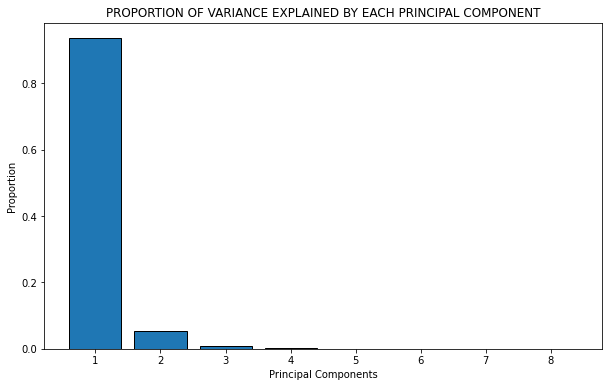

In [9]:
plt.figure(figsize=[10,6])
plt.bar(np.arange(1,len(eigval_us) + 1), df_eigval_us["Explained Proportion"], edgecolor = 'k' )
plt.title('PROPORTION OF VARIANCE EXPLAINED BY EACH PRINCIPAL COMPONENT')
plt.ylabel('Proportion')
plt.xlabel('Principal Components')
plt.show()

We will only focus on the first 3 PCs, as they explain 99.82% of yield curve movement

In [7]:

df_eigvec_us = pd.DataFrame([eigvec_us.T[0], eigvec_us.T[1], eigvec_us.T[2]], index = ['Loading for PC1', 'Loading for PC2','Loading for PC3'], columns = us_dm.columns)
df_eigvec_us


,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
Loading for PC1,-0.395855,-0.414369,-0.410796,-0.383622,-0.351987,-0.323266,-0.262384,-0.241738
Loading for PC2,-0.544472,-0.354091,-0.190836,0.084929,0.244496,0.333307,0.404695,0.447089
Loading for PC3,0.595586,-0.104186,-0.369997,-0.363189,-0.205711,0.046616,0.077623,0.561341


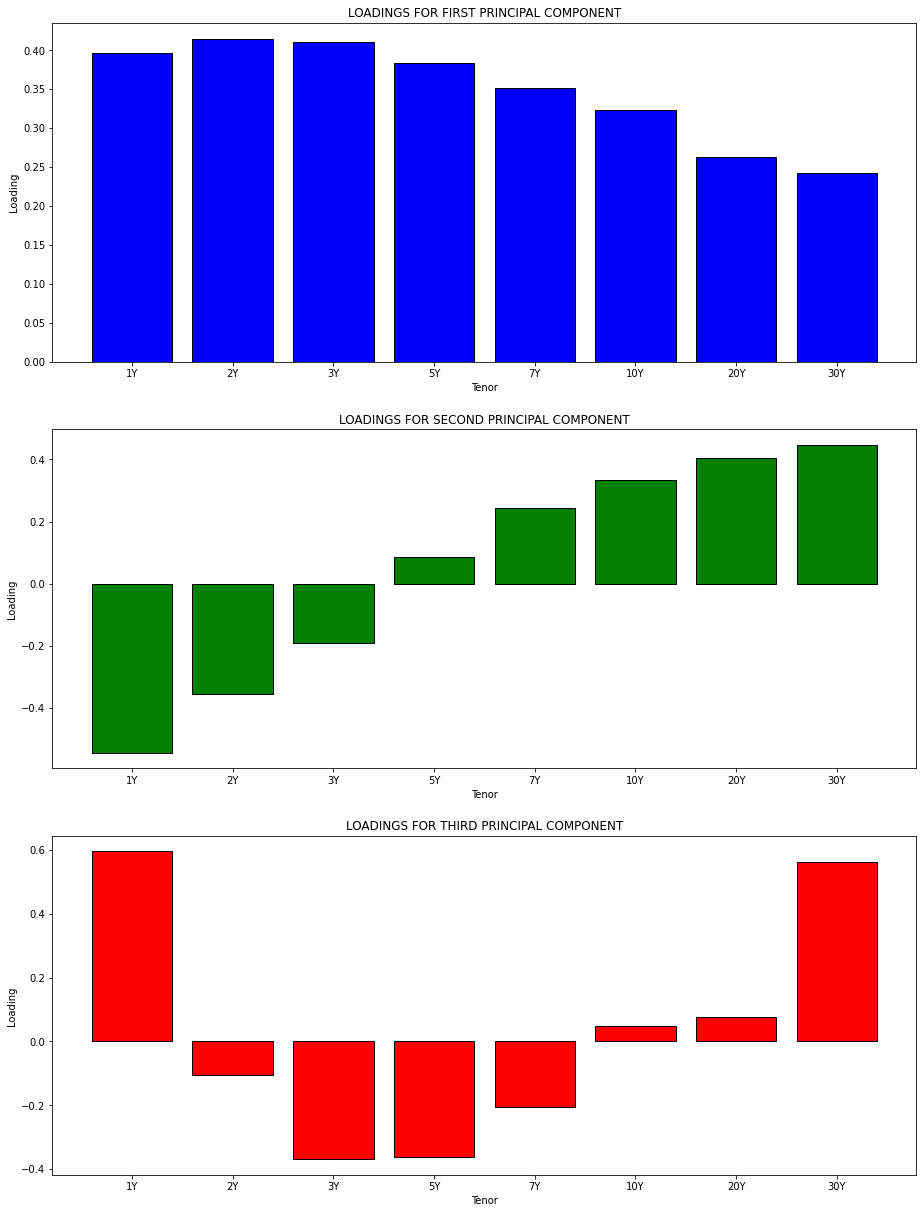

In [14]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows = 3, ncols = 1)

plt.subplots_adjust(left=0, right=2)
plt.subplots_adjust(bottom=0, top=4)

ax1.bar(us_dm.columns, - eigvec_us.T[0], color = 'b', edgecolor = 'k')
ax1.set_title('LOADINGS FOR FIRST PRINCIPAL COMPONENT')
ax1.set_xlabel('Tenor')
ax1.set_ylabel('Loading')

ax2.bar(us_dm.columns, eigvec_us.T[1], color = 'g', edgecolor = 'k')
ax2.set_title('LOADINGS FOR SECOND PRINCIPAL COMPONENT')
ax2.set_xlabel('Tenor')
ax2.set_ylabel('Loading')

ax3.bar(us_dm.columns, eigvec_us.T[2], color = 'r', edgecolor = 'k')
ax3.set_title('LOADINGS FOR THIRD PRINCIPAL COMPONENT')
ax3.set_xlabel('Tenor')
ax3.set_ylabel('Loading')

plt.show()

As expected, the PCs have intuitive interpretations,
- PC1: level of the yield curve (affects all tenors similarly)
- PC2: slope of the yield curve  (opposite effect on lower and higher tenors)
- PC3: curvature of the yield curve  (similar effect on lower and higher tenors, opposite effect on medium tenors)

In [15]:
pc_us = us_dm.dot(eigvec_us)
pc_us.drop(columns = [3,4,5,6,7], inplace = True)
pc_us.columns = ['PC1','PC2','PC3']
pc_us['PC1'] = - pc_us['PC1']
pc_us

,PC1,PC2,PC3
Date,,,
2016-01-04,0.078513,0.926364,-0.025159
2016-01-05,0.136975,0.908147,0.030384
2016-01-06,-0.031740,0.829389,0.048582
2016-01-07,-0.113157,0.812164,0.068820
2016-01-08,-0.178221,0.804703,0.079303
...,...,...,...
2022-06-13,4.874930,-0.058083,-0.331519
2022-06-14,5.095966,-0.154023,-0.206493
2022-06-15,4.553219,-0.081416,-0.139592


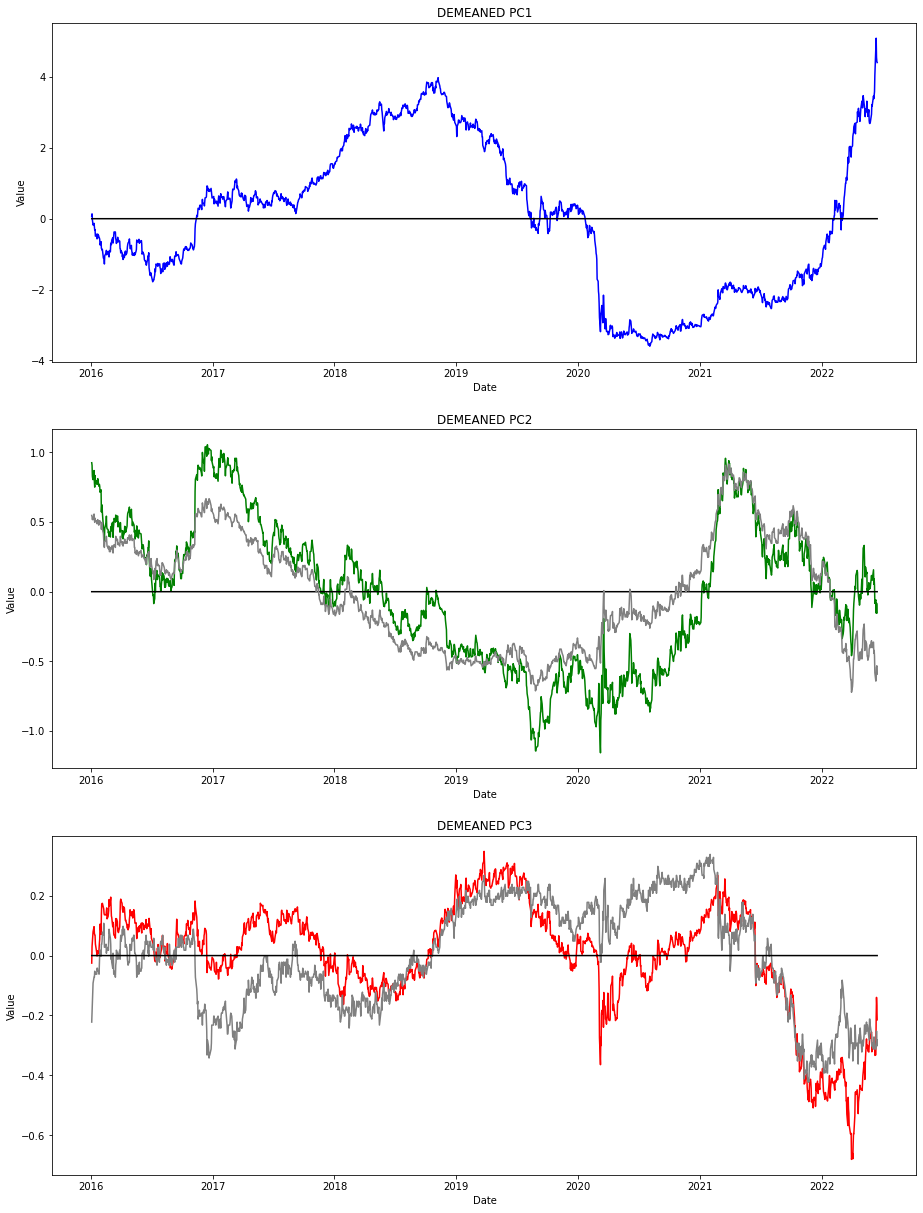

In [16]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows = 3, ncols = 1)

plt.subplots_adjust(left=0, right=2)
plt.subplots_adjust(bottom=0, top=4)

ax1.plot(date_us, pc_us['PC1'], color = 'b')
ax1.plot(date_us, np.zeros_like(pc_us['PC1']), color = 'k')
ax1.set_title('DEMEANED PC1')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value')

ax2.plot(date_us, pc_us['PC2'], color = 'g')
ax2.plot(date_us, np.zeros_like(pc_us['PC2']), color = 'k')
ax2.plot(date_us, us_dm['10Y'] - us_dm['2Y'], color = 'grey')
ax2.set_title('DEMEANED PC2')
ax2.set_xlabel('Date')
ax2.set_ylabel('Value')

ax3.plot(date_us, pc_us['PC3'], color = 'r')
ax3.plot(date_us, us_dm['2Y'] + us_dm['10Y'] - (2 * us_dm['5Y']), color = 'grey')
ax3.plot(date_us, np.zeros_like(pc_us['PC3']), color = 'k')
ax3.set_title('DEMEANED PC3')
ax3.set_xlabel('Date')
ax3.set_ylabel('Value')

plt.show()

The grey line in panel 2 is the term spread, i.e., 10Y - 2Y, while the grey line in panel 3 is a 2Y-5Y-10Y butterfly spread. We can see the close similarity of these spreads with the principal components of slope and curvature respectively.

The first PC seems to proxy the central bank policy, with a sharp dip during the onset of the pandemic and a steep rise in combat of inflation 

## PCA FOR UK (full sample)

In [17]:
uk_dm = uk.copy()
uk_dm.set_index('Date',inplace = True)

for j in range(uk_dm.shape[1]):
    mu = np.mean(uk_dm.iloc[:,j])
    for i in range(uk_dm.shape[0]):
        uk_dm.iloc[i,j] = uk_dm.iloc[i,j] - mu

In [18]:
uk_dm

,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
Date,,,,,,,,
2016-01-04,-0.031081,0.206965,0.420058,0.681964,0.807585,0.884536,1.077054,1.122701
2016-01-05,-0.048425,0.189211,0.402475,0.667407,0.798315,0.880244,1.069522,1.118196
2016-01-06,-0.081103,0.130854,0.337914,0.594745,0.718085,0.794610,0.999487,1.052671
2016-01-07,-0.068012,0.136870,0.337539,0.594396,0.723980,0.808950,1.028274,1.090189
2016-01-08,-0.068944,0.114000,0.303189,0.553076,0.682871,0.771659,1.005906,1.072181
...,...,...,...,...,...,...,...,...
2022-06-10,1.503427,1.663450,1.639965,1.526639,1.442125,1.364846,1.080229,0.941982
2022-06-13,1.583111,1.736034,1.714799,1.606969,1.524166,1.443086,1.148523,1.006340
2022-06-14,1.598978,1.733916,1.708778,1.612655,1.550357,1.495760,1.226609,1.083771


In [19]:
cov_uk = np.array(uk_dm.cov())

eigval_uk, eigvec_uk = np.linalg.eig(cov_uk)

df_eigval_uk = pd.DataFrame({"Eigenvalues":eigval_uk})
df_eigval_uk["Explained Proportion"] = df_eigval_uk["Eigenvalues"] / np.sum(df_eigval_uk["Eigenvalues"])
df_eigval_uk.style.format({"Explained Proportion": "{:.2%}"})

,Eigenvalues,Explained Proportion
0,1.210869,82.17%
1,0.242387,16.45%
2,0.018701,1.27%
3,0.001032,0.07%
4,0.000467,0.03%
5,0.000166,0.01%
6,0.000004,0.00%
7,0.000000,0.00%


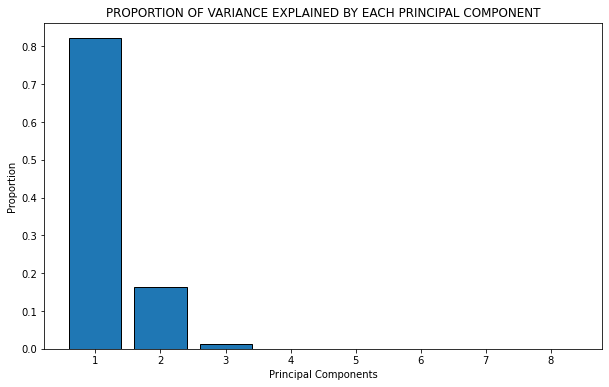

In [20]:
plt.figure(figsize=[10,6])
plt.bar(np.arange(1,len(eigval_uk) + 1), df_eigval_uk["Explained Proportion"], edgecolor = 'k' )
plt.title('PROPORTION OF VARIANCE EXPLAINED BY EACH PRINCIPAL COMPONENT')
plt.ylabel('Proportion')
plt.xlabel('Principal Components')
plt.show()

An interesting observation here is that PCs 2 and 3 explain almost 3 times more variation in the yield curve of UK versus the US.

In [23]:
df_eigvec_uk = pd.DataFrame([-eigvec_uk.T[0], eigvec_uk.T[1], eigvec_uk.T[2]], index = ['Loading for PC1', 'Loading for PC2','Loading for PC3'], columns = uk_dm.columns)
df_eigvec_uk

,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
Loading for PC1,0.244747,0.283332,0.312652,0.358063,0.387970,0.410880,0.407294,0.385527
Loading for PC2,-0.452665,-0.452958,-0.371834,-0.173881,-0.004301,0.165662,0.426391,0.460605
Loading for PC3,0.570181,0.131336,-0.071478,-0.288876,-0.399045,-0.397778,0.238538,0.441274


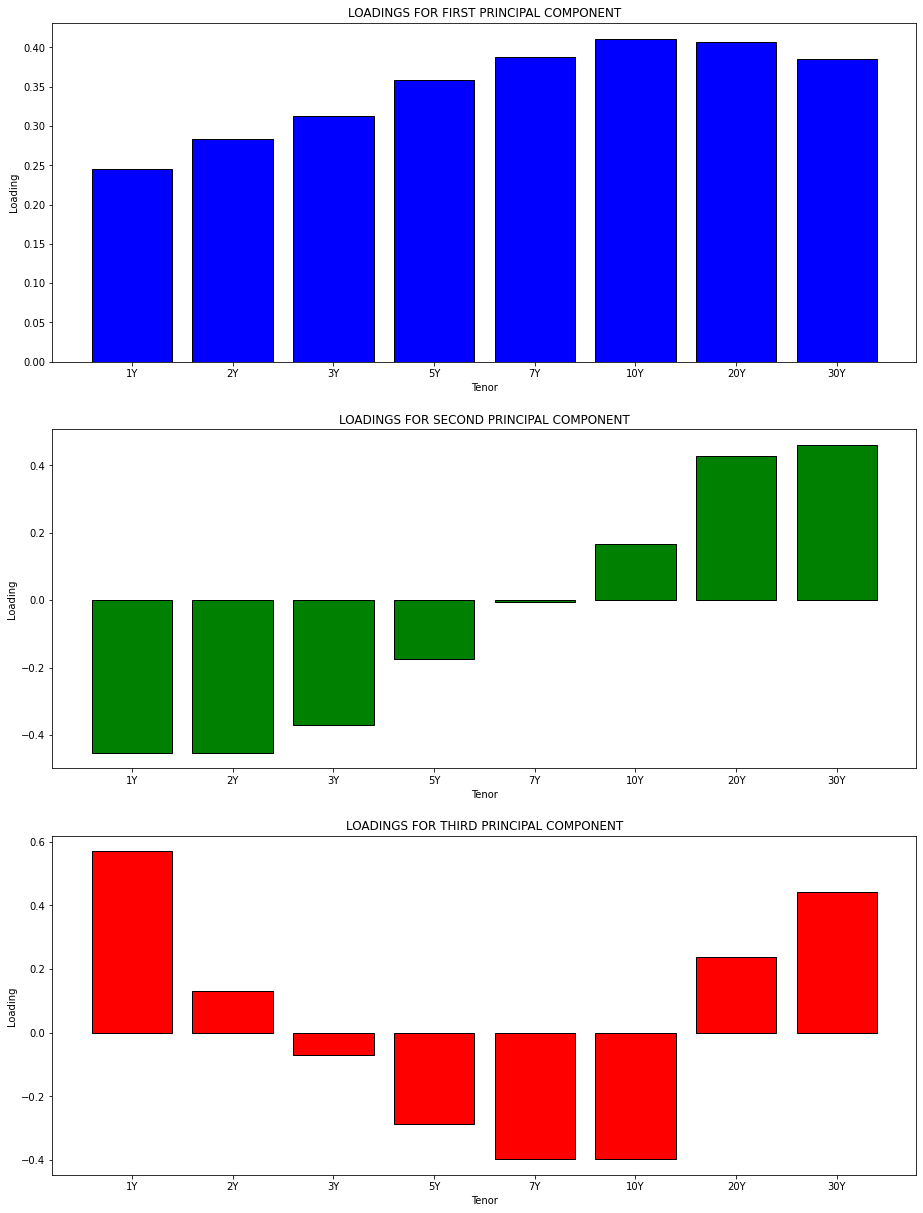

In [25]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows = 3, ncols = 1)

plt.subplots_adjust(left=0, right=2)
plt.subplots_adjust(bottom=0, top=4)

ax1.bar(uk_dm.columns, -eigvec_uk.T[0], color = 'b', edgecolor = 'k')
ax1.set_title('LOADINGS FOR FIRST PRINCIPAL COMPONENT')
ax1.set_xlabel('Tenor')
ax1.set_ylabel('Loading')

ax2.bar(uk_dm.columns, eigvec_uk.T[1], color = 'g', edgecolor = 'k')
ax2.set_title('LOADINGS FOR SECOND PRINCIPAL COMPONENT')
ax2.set_xlabel('Tenor')
ax2.set_ylabel('Loading')

ax3.bar(uk_dm.columns, eigvec_uk.T[2], color = 'r', edgecolor = 'k')
ax3.set_title('LOADINGS FOR THIRD PRINCIPAL COMPONENT')
ax3.set_xlabel('Tenor')
ax3.set_ylabel('Loading')

plt.show()

In [26]:
pc_uk = uk_dm.dot(eigvec_uk)
pc_uk.drop(columns = [3,4,5,6,7], inplace = True)
pc_uk.columns = ['PC1','PC2','PC3']
pc_uk['PC1'] = - pc_uk['PC1']
pc_uk

,PC1,PC2,PC3
Date,,,
2016-01-04,1.974816,0.764979,-0.139342
2016-01-05,1.944666,0.783984,-0.144480
2016-01-06,1.753833,0.787965,-0.124713
2016-01-07,1.792867,0.811420,-0.100965
2016-01-08,1.713301,0.818325,-0.072152
...,...,...,...
2022-06-10,3.822057,-1.194887,0.072435
2022-06-13,4.030889,-1.234256,0.079678
2022-06-14,4.127785,-1.161656,0.108625


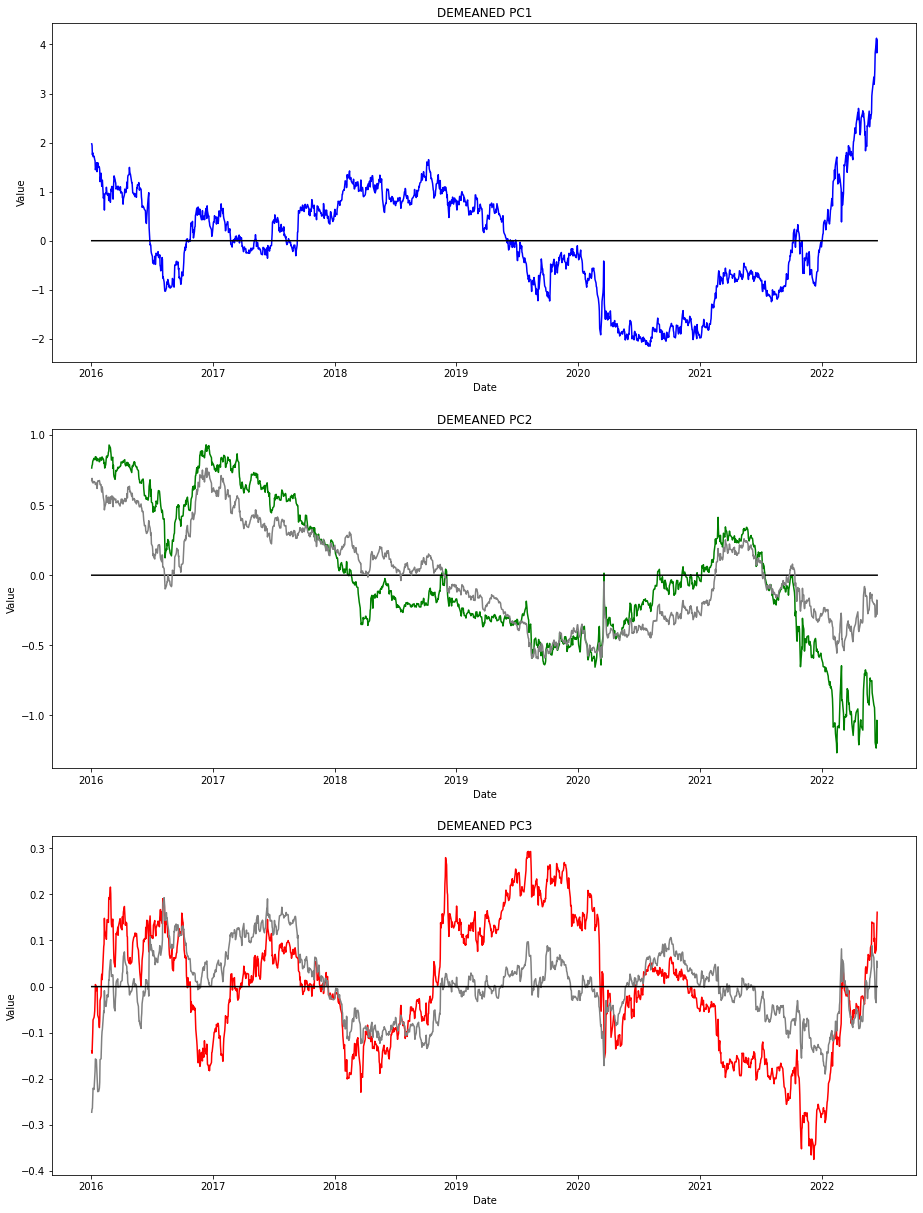

In [27]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows = 3, ncols = 1)

plt.subplots_adjust(left=0, right=2)
plt.subplots_adjust(bottom=0, top=4)

ax1.plot(date_uk, pc_uk['PC1'], color = 'b')
ax1.plot(date_uk, np.zeros_like(pc_uk['PC1']), color = 'k')
ax1.set_title('DEMEANED PC1')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value')

ax2.plot(date_uk, pc_uk['PC2'], color = 'g')
ax2.plot(date_uk, np.zeros_like(pc_uk['PC2']), color = 'k')
ax2.plot(date_uk, uk_dm['10Y'] - uk_dm['2Y'], color = 'grey')
ax2.set_title('DEMEANED PC2')
ax2.set_xlabel('Date')
ax2.set_ylabel('Value')

ax3.plot(date_uk, pc_uk['PC3'], color = 'r')
ax3.plot(date_uk, uk_dm['2Y'] + uk_dm['10Y'] - (2 * uk_dm['5Y']), color = 'grey')
ax3.plot(date_uk, np.zeros_like(pc_uk['PC3']), color = 'k')
ax3.set_title('DEMEANED PC3')
ax3.set_xlabel('Date')
ax3.set_ylabel('Value')

plt.show()


- PCs 2 and 3 explain almost 3 times more variation in the yield curve of UK versus US
- observing the factor loadings, shorter tenors are more sensitive to PC1 in  US yield curve, whereas longer tenors are more sensitive to PC1 in the UK yield curve. Sensitivity of shorter tenors is symptomatic of an active central bank, moving the yield curve. This can be confirmed by the following graph comparing the Fed Funds rate to the UK bank rate


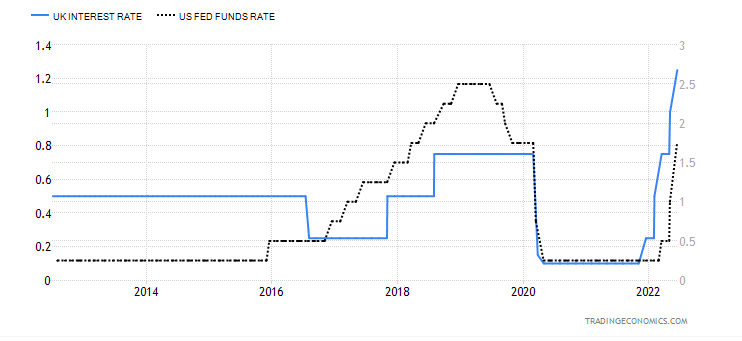

In [30]:
from IPython.display import display, Image
display(Image(filename='rates.png'))

# LHS is the scale for UK, RHS for US

The market has gone through significant structural changes over the period of we are studying, with the pandemic accomodation and then inflation-hawkishness thereafter. Hence it would be sensible to study the sample pre- and post-covid. 



## US (Before and after COVID)

In [101]:
us_bc = us_dm.loc[:d.datetime(2019,12,31)]
date_us_bc = date_us[:date_us.index(d.datetime(2019,12,31)) + 1]
us_ac = us_dm.loc[d.datetime(2020,1,2):]
date_us_ac = date_us[date_us.index(d.datetime(2020,1,2)):]

In [102]:
cov_us_bc = np.array(us_bc.cov())

eigval_us_bc, eigvec_us_bc = np.linalg.eig(cov_us_bc)
df_eigval_us_bc = pd.DataFrame({"Eigenvalues":eigval_us_bc})
df_eigval_us_bc["Explained Proportion"] = df_eigval_us_bc["Eigenvalues"] / np.sum(df_eigval_us_bc["Eigenvalues"])

cov_us_ac = np.array(us_ac.cov())

eigval_us_ac, eigvec_us_ac = np.linalg.eig(cov_us_ac)

df_eigval_us_ac = pd.DataFrame({"Eigenvalues":eigval_us_ac})
df_eigval_us_ac["Explained Proportion"] = df_eigval_us_ac["Eigenvalues"] / np.sum(df_eigval_us_ac["Eigenvalues"])

In [103]:
df_eigval_us_bc.style.format({"Explained Proportion": "{:.2%}"})

,Eigenvalues,Explained Proportion
0,2.241446,90.33%
1,0.226800,9.14%
2,0.011183,0.45%
3,0.001239,0.05%
4,0.000446,0.02%
5,0.000116,0.00%
6,0.000093,0.00%
7,0.000048,0.00%


In [104]:
df_eigval_us_ac.style.format({"Explained Proportion": "{:.2%}"})

,Eigenvalues,Explained Proportion
0,3.549680,92.49%
1,0.253821,6.61%
2,0.030254,0.79%
3,0.003092,0.08%
4,0.000522,0.01%
5,0.000240,0.01%
6,0.000068,0.00%
7,0.000112,0.00%


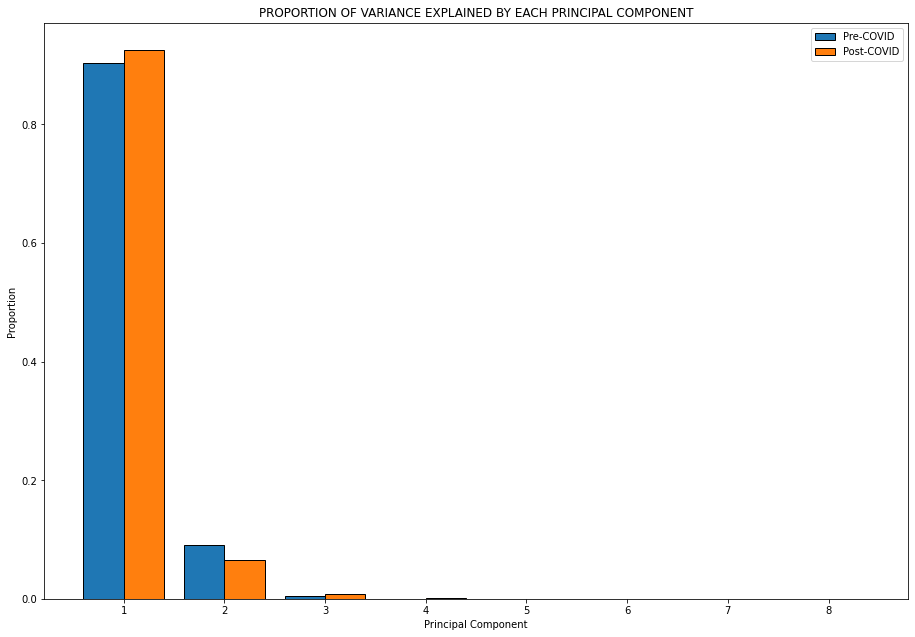

In [108]:
fig,ax1 = plt.subplots(1,1)

plt.subplots_adjust(left=0, right=2)
plt.subplots_adjust(bottom=0, top=2)

x = np.arange(1,len(eigval_us_bc) + 1)

ax1.bar(x - 0.2 , df_eigval_us_bc["Explained Proportion"], edgecolor = 'k', width = 0.4, label = 'Pre-COVID' )
ax1.bar(x + 0.2, df_eigval_us_ac["Explained Proportion"], edgecolor = 'k', width = 0.4, label = 'Post-COVID' )

ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion')
ax1.set_title('PROPORTION OF VARIANCE EXPLAINED BY EACH PRINCIPAL COMPONENT')
ax1.set_xticks(x)
ax1.legend()


plt.show()

In [113]:
df_eigvec_us_bc = pd.DataFrame([ - eigvec_us_bc.T[0], - eigvec_us_bc.T[1], eigvec_us_bc.T[2]], index = ['Loading for PC1', 'Loading for PC2','Loading for PC3'], columns = us_bc.columns)
df_eigvec_us_ac = pd.DataFrame([ - eigvec_us_ac.T[0], eigvec_us_ac.T[1], - eigvec_us_ac.T[2]], index = ['Loading for PC1', 'Loading for PC2','Loading for PC3'], columns = us_ac.columns)

In [114]:
df_eigvec_us_bc

,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
Loading for PC1,0.456200,0.447395,0.427667,0.373068,0.325883,0.293543,0.226695,0.160877
Loading for PC2,-0.557800,-0.285801,-0.096819,0.161060,0.296588,0.360653,0.395471,0.444331
Loading for PC3,0.510056,-0.086425,-0.289537,-0.371988,-0.273941,-0.033492,0.338695,0.565055


In [115]:
df_eigvec_us_ac

,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
Loading for PC1,0.325280,0.409527,0.428714,0.406788,0.369649,0.325172,0.289171,0.226299
Loading for PC2,-0.454983,-0.401296,-0.276719,0.022952,0.216109,0.351335,0.470175,0.404533
Loading for PC3,0.654126,0.025759,-0.315707,-0.400291,-0.247484,0.023529,0.185682,0.463973


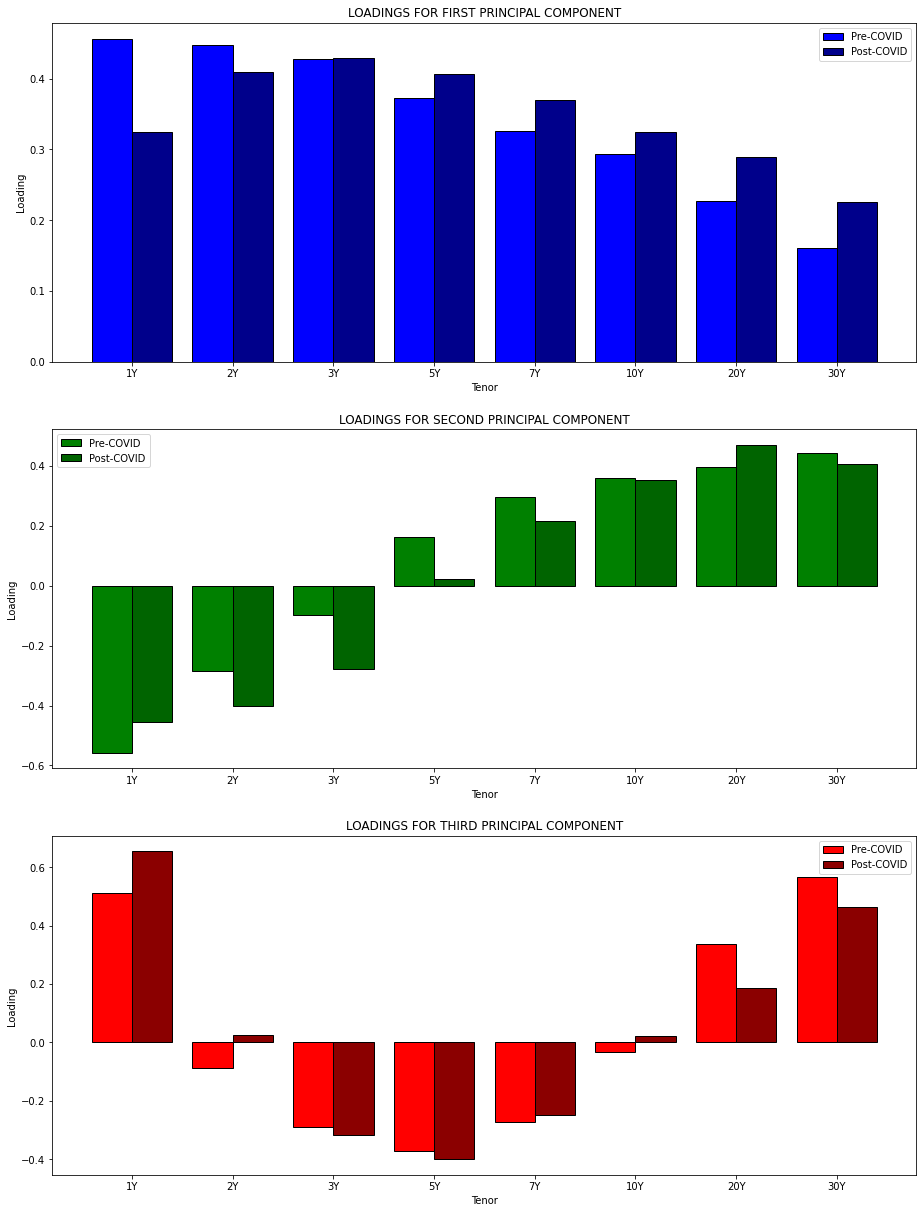

In [120]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows = 3, ncols = 1)

plt.subplots_adjust(left=0, right=2)
plt.subplots_adjust(bottom=0, top=4)
l = list(us_bc.columns)
x = np.arange(1,9)

ax1.bar(x - 0.2, - eigvec_us_bc.T[0], color = 'b', edgecolor = 'k',width = 0.4, label = 'Pre-COVID')
ax1.bar(x + 0.2, - eigvec_us_ac.T[0], color = 'darkblue', edgecolor = 'k',width = 0.4, label = 'Post-COVID')
ax1.set_title('LOADINGS FOR FIRST PRINCIPAL COMPONENT')
ax1.set_xlabel('Tenor')
ax1.set_ylabel('Loading')
ax1.set_xticks(x,l)
ax1.legend()

ax2.bar(x - 0.2, -eigvec_us_bc.T[1], color = 'g', edgecolor = 'k',width = 0.4, label = 'Pre-COVID')
ax2.bar(x + 0.2, eigvec_us_ac.T[1], color = 'darkgreen', edgecolor = 'k',width = 0.4, label = 'Post-COVID')
ax2.set_title('LOADINGS FOR SECOND PRINCIPAL COMPONENT')
ax2.set_xlabel('Tenor')
ax2.set_ylabel('Loading')
ax2.set_xticks(x,l)
ax2.legend()

ax3.bar(x - 0.2, eigvec_us_bc.T[2], color = 'r', edgecolor = 'k',width = 0.4, label = 'Pre-COVID')
ax3.bar(x + 0.2, -eigvec_us_ac.T[2], color = 'darkred', edgecolor = 'k',width = 0.4, label = 'Post-COVID')
ax3.set_title('LOADINGS FOR THIRD PRINCIPAL COMPONENT')
ax3.set_xlabel('Tenor')
ax3.set_ylabel('Loading')
ax3.set_xticks(x,l)
ax3.legend()

plt.show()

In [137]:
pc_us_bc = us_bc.dot(eigvec_us_bc)
pc_us_bc.drop(columns = [3,4,5,6,7], inplace = True)
pc_us_bc.columns = ['PC1','PC2','PC3']

pc_us_ac = us_ac.dot(eigvec_us_ac)
pc_us_ac.drop(columns = [3,4,5,6,7], inplace = True)
pc_us_ac.columns = ['PC1','PC2','PC3']


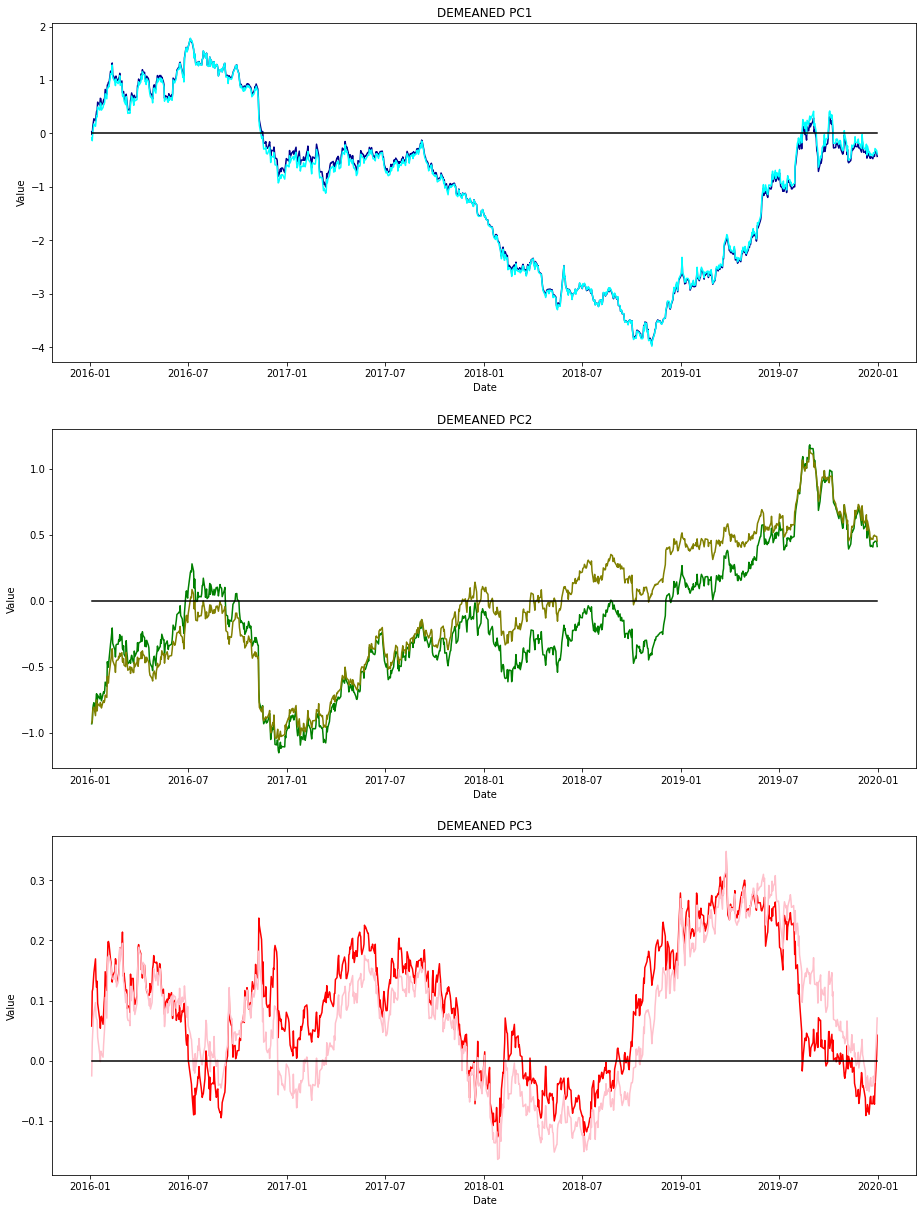

In [138]:
# comparing PC evolution of full and split sample: pre-COVID

fig,(ax1,ax2,ax3) = plt.subplots(nrows = 3, ncols = 1)

plt.subplots_adjust(left=0, right=2)
plt.subplots_adjust(bottom=0, top=4)

ax1.plot(date_us_bc, pc_us_bc['PC1'], color = 'darkblue')
ax1.plot(date_us_bc,  -pc_us.loc[:date_us_bc[-1],'PC1'], color = 'cyan')
ax1.plot(date_us_bc, np.zeros_like(pc_us_bc['PC1']), color = 'k')
ax1.set_title('DEMEANED PC1')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value')

ax2.plot(date_us_bc, pc_us_bc['PC2'], color = 'green')
ax2.plot(date_us_bc,  -pc_us.loc[:date_us_bc[-1],'PC2'], color = 'olive')
ax2.plot(date_us_bc, np.zeros_like(pc_us_bc['PC2']), color = 'k')
ax2.set_title('DEMEANED PC2')
ax2.set_xlabel('Date')
ax2.set_ylabel('Value')

ax3.plot(date_us_bc, pc_us_bc['PC3'], color = 'red')
ax3.plot(date_us_bc, pc_us.loc[:date_us_bc[-1],'PC3'], color = 'pink')
ax3.plot(date_us_bc, np.zeros_like(pc_us_bc['PC3']), color = 'k')
ax3.set_title('DEMEANED PC3')
ax3.set_xlabel('Date')
ax3.set_ylabel('Value')

plt.show()

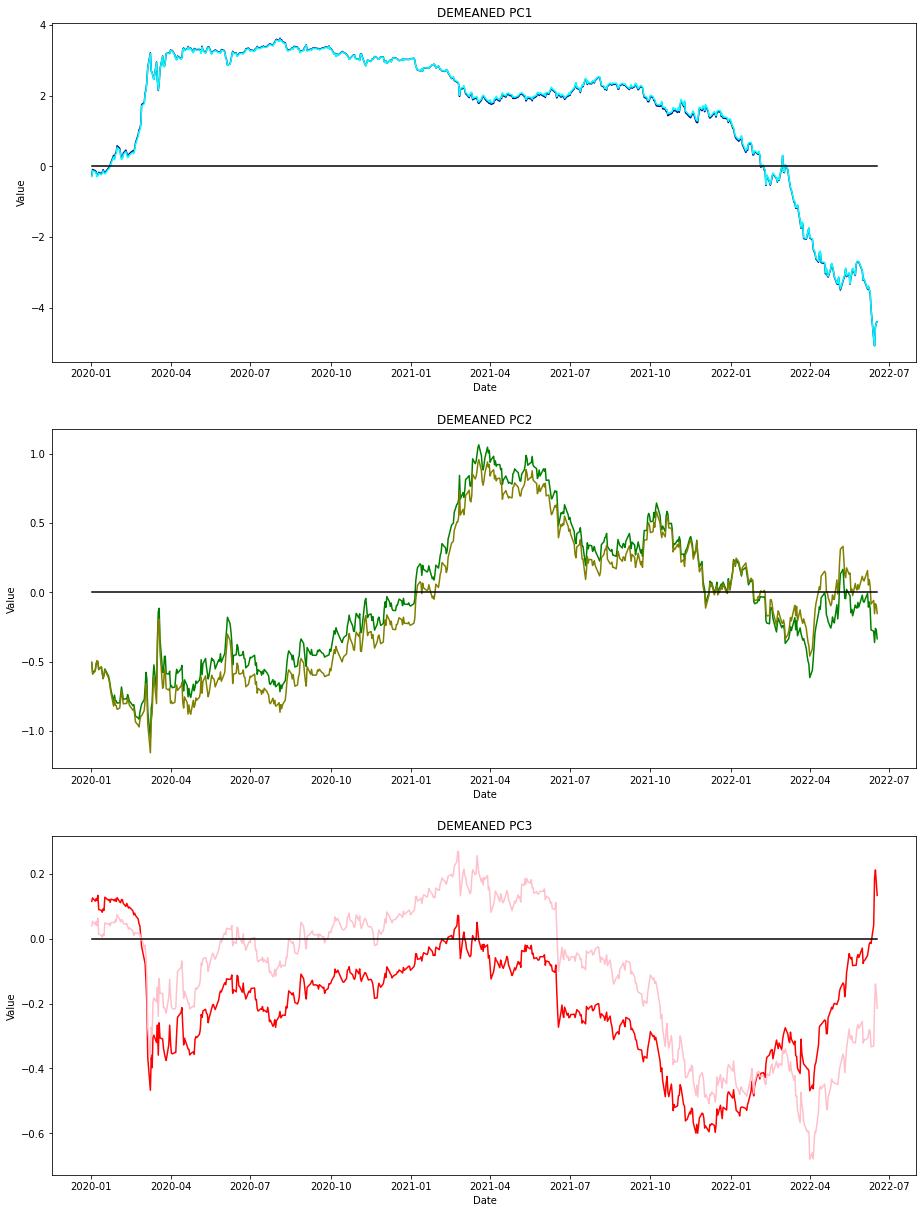

In [144]:
# comparing PC evolution of full and split sample: post-COVID

fig,(ax1,ax2,ax3) = plt.subplots(nrows = 3, ncols = 1)

plt.subplots_adjust(left=0, right=2)
plt.subplots_adjust(bottom=0, top=4)

ax1.plot(date_us_ac, pc_us_ac['PC1'], color = 'darkblue')
ax1.plot(date_us_ac,  -pc_us.loc[date_us_ac[0]:,'PC1'], color = 'cyan')
ax1.plot(date_us_ac, np.zeros_like(pc_us_ac['PC1']), color = 'k')
ax1.set_title('DEMEANED PC1')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value')

ax2.plot(date_us_ac, pc_us_ac['PC2'], color = 'green')
ax2.plot(date_us_ac,  pc_us.loc[date_us_ac[0]:,'PC2'], color = 'olive')
ax2.plot(date_us_ac, np.zeros_like(pc_us_ac['PC2']), color = 'k')
ax2.set_title('DEMEANED PC2')
ax2.set_xlabel('Date')
ax2.set_ylabel('Value')

ax3.plot(date_us_ac, -pc_us_ac['PC3'], color = 'red')
ax3.plot(date_us_ac, pc_us.loc[date_us_ac[0]:,'PC3'], color = 'pink')
ax3.plot(date_us_ac, np.zeros_like(pc_us_ac['PC3']), color = 'k')
ax3.set_title('DEMEANED PC3')
ax3.set_xlabel('Date')
ax3.set_ylabel('Value')

plt.show()

- Eigenvectors are not stable through time, and differ significantly for certain tenors such long and short end of the yield curve for PC1, and flip sign for 2Y and 10Y for PC3
- Full sample and split sample PCs have an increasing discrepancy in $i \in \{1,2,3\}$ for $PC_i$

## UK (Before and after COVID)

In [145]:
uk_bc = uk_dm.loc[:d.datetime(2019,12,31)]
date_uk_bc = date_uk[:date_uk.index(d.datetime(2019,12,31)) + 1]
uk_ac = uk_dm.loc[d.datetime(2020,1,2):]
date_uk_ac = date_uk[date_uk.index(d.datetime(2020,1,2)):]

In [146]:
cov_uk_bc = np.array(uk_bc.cov())

eigval_uk_bc, eigvec_uk_bc = np.linalg.eig(cov_uk_bc)
df_eigval_uk_bc = pd.DataFrame({"Eigenvalues":eigval_uk_bc})
df_eigval_uk_bc["Explained Proportion"] = df_eigval_uk_bc["Eigenvalues"] / np.sum(df_eigval_uk_bc["Eigenvalues"])

cov_uk_ac = np.array(uk_ac.cov())

eigval_uk_ac, eigvec_uk_ac = np.linalg.eig(cov_uk_ac)

df_eigval_uk_ac = pd.DataFrame({"Eigenvalues":eigval_uk_ac})
df_eigval_uk_ac["Explained Proportion"] = df_eigval_uk_ac["Eigenvalues"] / np.sum(df_eigval_uk_ac["Eigenvalues"])

In [147]:
df_eigval_uk_bc.style.format({"Explained Proportion": "{:.2%}"})

,Eigenvalues,Explained Proportion
0,0.447115,66.76%
1,0.212150,31.68%
2,0.009260,1.38%
3,0.000918,0.14%
4,0.000160,0.02%
5,0.000091,0.01%
6,0.000003,0.00%
7,0.000000,0.00%


In [148]:
df_eigval_uk_ac.style.format({"Explained Proportion": "{:.2%}"})

,Eigenvalues,Explained Proportion
0,1.848123,95.11%
1,0.079919,4.11%
2,0.014184,0.73%
3,0.000659,0.03%
4,0.000195,0.01%
5,0.000120,0.01%
6,0.000003,0.00%
7,0.000000,0.00%


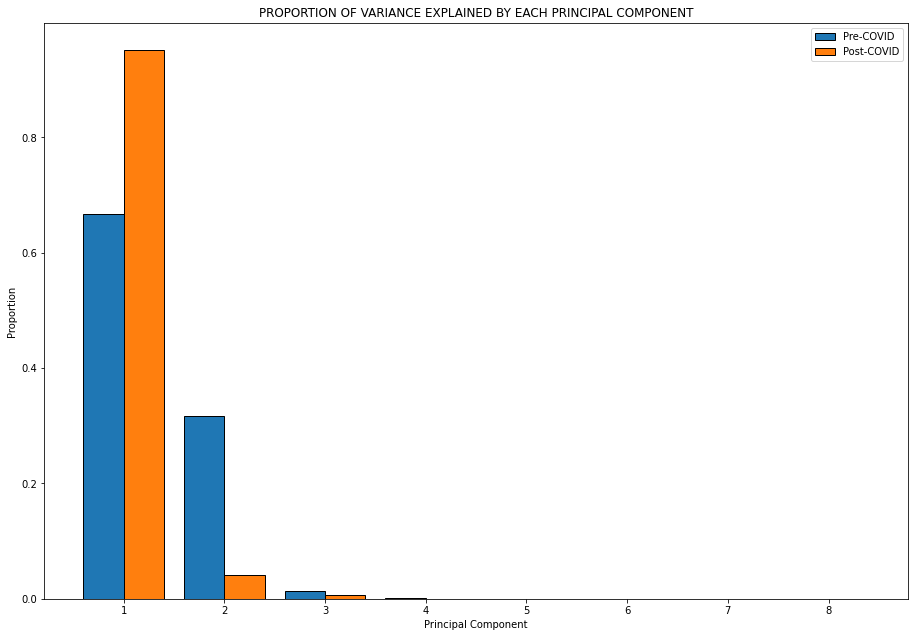

In [149]:
fig,ax1 = plt.subplots(1,1)

plt.subplots_adjust(left=0, right=2)
plt.subplots_adjust(bottom=0, top=2)

x = np.arange(1,len(eigval_uk_bc) + 1)

ax1.bar(x - 0.2 , df_eigval_uk_bc["Explained Proportion"], edgecolor = 'k', width = 0.4, label = 'Pre-COVID' )
ax1.bar(x + 0.2, df_eigval_uk_ac["Explained Proportion"], edgecolor = 'k', width = 0.4, label = 'Post-COVID' )

ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion')
ax1.set_title('PROPORTION OF VARIANCE EXPLAINED BY EACH PRINCIPAL COMPONENT')
ax1.set_xticks(x)
ax1.legend()


plt.show()

In [155]:
df_eigvec_uk_bc = pd.DataFrame([ eigvec_uk_bc.T[0], eigvec_uk_bc.T[1],  - eigvec_uk_bc.T[2]], index = ['Loading for PC1', 'Loading for PC2','Loading for PC3'], columns = us_bc.columns)
df_eigvec_uk_ac = pd.DataFrame([ - eigvec_uk_ac.T[0], eigvec_uk_ac.T[1],  eigvec_uk_ac.T[2]], index = ['Loading for PC1', 'Loading for PC2','Loading for PC3'], columns = us_ac.columns)

In [156]:
df_eigvec_uk_bc

,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
Loading for PC1,0.095609,0.180127,0.254809,0.363036,0.426522,0.463773,0.437731,0.416024
Loading for PC2,-0.520545,-0.486193,-0.412357,-0.232408,-0.065052,0.111019,0.353746,0.356237
Loading for PC3,0.480510,0.140217,0.005325,-0.204717,-0.360647,-0.425582,0.262524,0.572195


In [157]:
df_eigvec_uk_ac

,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
Loading for PC1,0.330942,0.376146,0.383823,0.382084,0.378568,0.372352,0.312393,0.275924
Loading for PC2,-0.451432,-0.407403,-0.297888,-0.058291,0.141310,0.319597,0.426751,0.483601
Loading for PC3,0.533326,0.075678,-0.132326,-0.319595,-0.378341,-0.322551,0.291778,0.507809


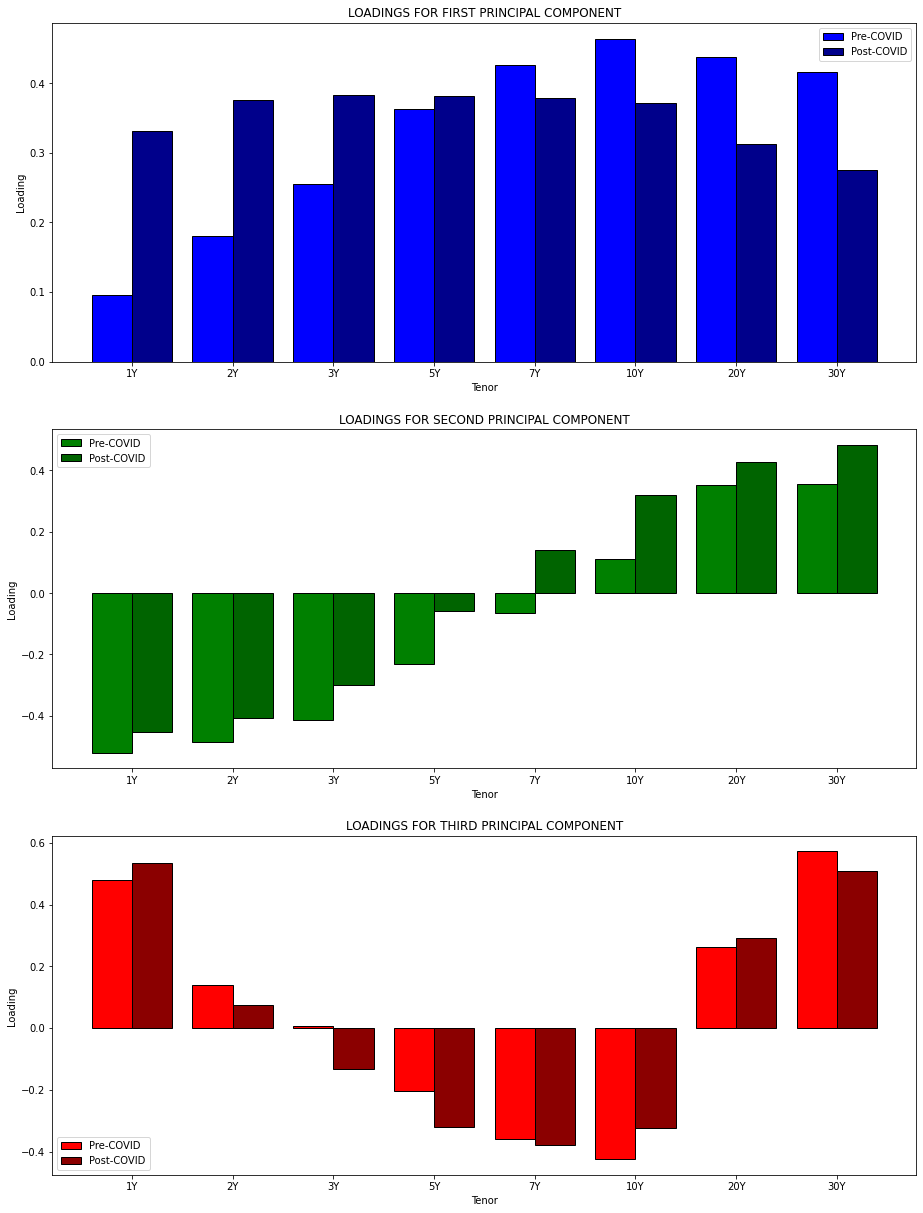

In [159]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows = 3, ncols = 1)

plt.subplots_adjust(left=0, right=2)
plt.subplots_adjust(bottom=0, top=4)
l = list(us_bc.columns)
x = np.arange(1,9)

ax1.bar(x - 0.2, eigvec_uk_bc.T[0], color = 'b', edgecolor = 'k',width = 0.4, label = 'Pre-COVID')
ax1.bar(x + 0.2, -eigvec_uk_ac.T[0], color = 'darkblue', edgecolor = 'k',width = 0.4, label = 'Post-COVID')
ax1.set_title('LOADINGS FOR FIRST PRINCIPAL COMPONENT')
ax1.set_xlabel('Tenor')
ax1.set_ylabel('Loading')
ax1.set_xticks(x,l)
ax1.legend()

ax2.bar(x - 0.2, eigvec_uk_bc.T[1], color = 'g', edgecolor = 'k',width = 0.4, label = 'Pre-COVID')
ax2.bar(x + 0.2, eigvec_uk_ac.T[1], color = 'darkgreen', edgecolor = 'k',width = 0.4, label = 'Post-COVID')
ax2.set_title('LOADINGS FOR SECOND PRINCIPAL COMPONENT')
ax2.set_xlabel('Tenor')
ax2.set_ylabel('Loading')
ax2.set_xticks(x,l)
ax2.legend()

ax3.bar(x - 0.2, -eigvec_uk_bc.T[2], color = 'r', edgecolor = 'k',width = 0.4, label = 'Pre-COVID')
ax3.bar(x + 0.2, eigvec_uk_ac.T[2], color = 'darkred', edgecolor = 'k',width = 0.4, label = 'Post-COVID')
ax3.set_title('LOADINGS FOR THIRD PRINCIPAL COMPONENT')
ax3.set_xlabel('Tenor')
ax3.set_ylabel('Loading')
ax3.set_xticks(x,l)
ax3.legend()

plt.show()

In [164]:
pc_uk_bc = uk_bc.dot(eigvec_uk_bc)
pc_uk_bc.drop(columns = [3,4,5,6,7], inplace = True)
pc_uk_bc.columns = ['PC1','PC2','PC3']

pc_uk_ac = uk_ac.dot(eigvec_uk_ac)
pc_uk_ac.drop(columns = [3,4,5,6,7], inplace = True)
pc_uk_ac.columns = ['PC1','PC2','PC3']


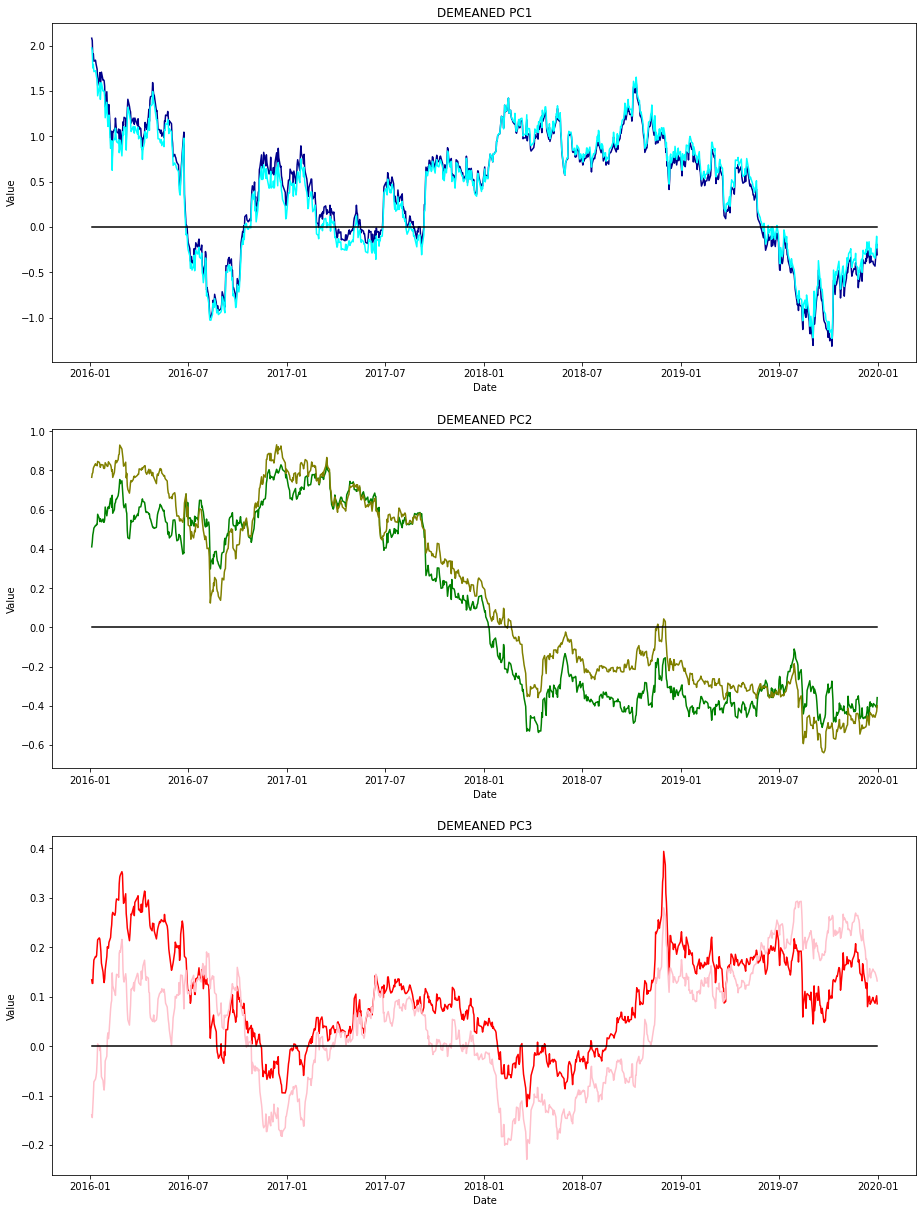

In [170]:
# comparing PC evolution of full and split sample: pre-COVID

fig,(ax1,ax2,ax3) = plt.subplots(nrows = 3, ncols = 1)

plt.subplots_adjust(left=0, right=2)
plt.subplots_adjust(bottom=0, top=4)

ax1.plot(date_uk_bc, pc_uk_bc['PC1'], color = 'darkblue')
ax1.plot(date_uk_bc,  pc_uk.loc[:date_uk_bc[-1],'PC1'], color = 'cyan')
ax1.plot(date_uk_bc, np.zeros_like(pc_uk_bc['PC1']), color = 'k')
ax1.set_title('DEMEANED PC1')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value')

ax2.plot(date_uk_bc, pc_uk_bc['PC2'], color = 'green')
ax2.plot(date_uk_bc, pc_uk.loc[:date_uk_bc[-1],'PC2'], color = 'olive')
ax2.plot(date_uk_bc, np.zeros_like(pc_uk_bc['PC2']), color = 'k')
ax2.set_title('DEMEANED PC2')
ax2.set_xlabel('Date')
ax2.set_ylabel('Value')

ax3.plot(date_uk_bc, -pc_uk_bc['PC3'], color = 'red')
ax3.plot(date_uk_bc, pc_uk.loc[:date_uk_bc[-1],'PC3'], color = 'pink')
ax3.plot(date_uk_bc, np.zeros_like(pc_uk_bc['PC3']), color = 'k')
ax3.set_title('DEMEANED PC3')
ax3.set_xlabel('Date')
ax3.set_ylabel('Value')

plt.show()

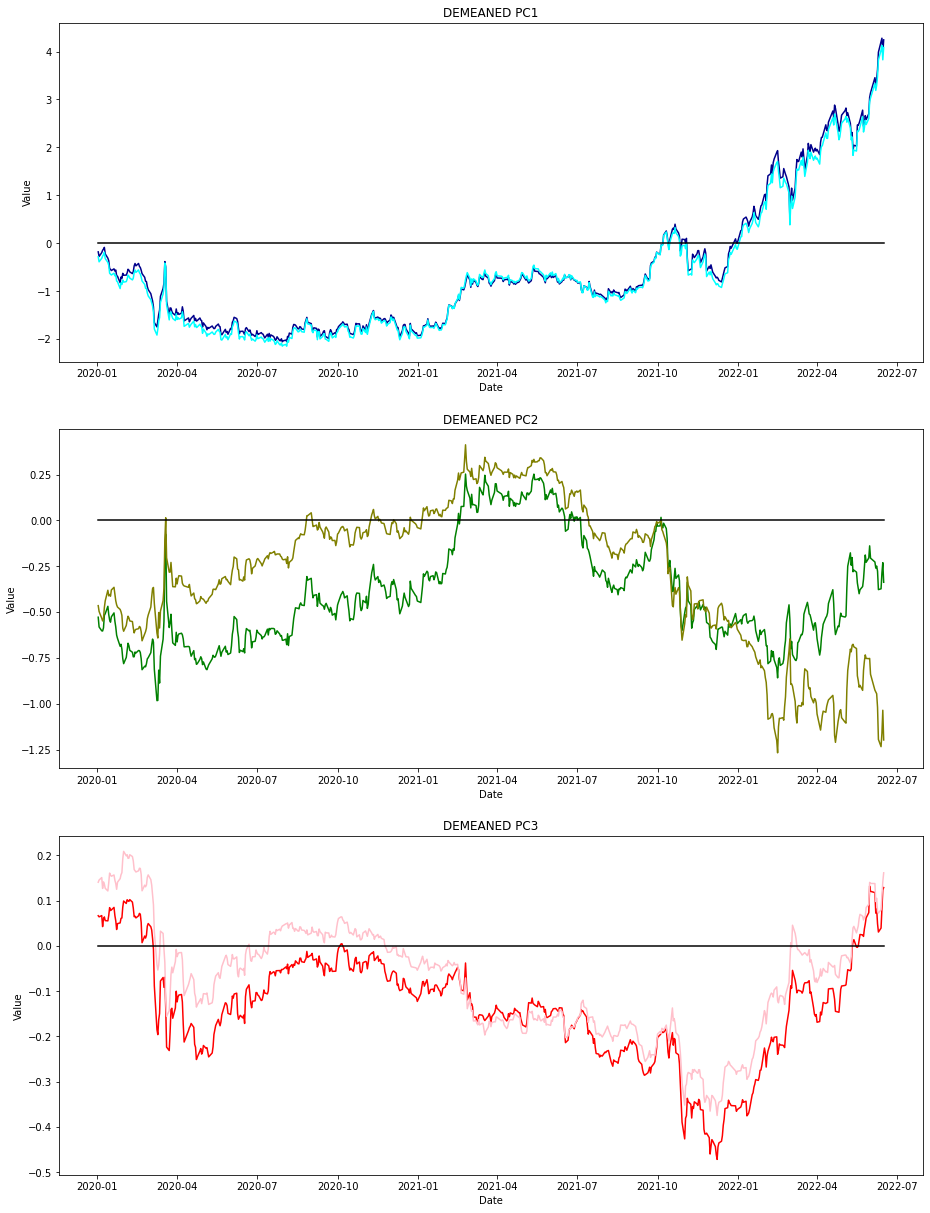

In [171]:
# comparing PC evolution of full and split sample: post-COVID

fig,(ax1,ax2,ax3) = plt.subplots(nrows = 3, ncols = 1)

plt.subplots_adjust(left=0, right=2)
plt.subplots_adjust(bottom=0, top=4)

ax1.plot(date_uk_ac, -pc_uk_ac['PC1'], color = 'darkblue')
ax1.plot(date_uk_ac,  pc_uk.loc[date_uk_ac[0]:,'PC1'], color = 'cyan')
ax1.plot(date_uk_ac, np.zeros_like(pc_uk_ac['PC1']), color = 'k')
ax1.set_title('DEMEANED PC1')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value')

ax2.plot(date_uk_ac, pc_uk_ac['PC2'], color = 'green')
ax2.plot(date_uk_ac,  pc_uk.loc[date_uk_ac[0]:,'PC2'], color = 'olive')
ax2.plot(date_uk_ac, np.zeros_like(pc_uk_ac['PC2']), color = 'k')
ax2.set_title('DEMEANED PC2')
ax2.set_xlabel('Date')
ax2.set_ylabel('Value')

ax3.plot(date_uk_ac, pc_uk_ac['PC3'], color = 'red')
ax3.plot(date_uk_ac, pc_uk.loc[date_uk_ac[0]:,'PC3'], color = 'pink')
ax3.plot(date_uk_ac, np.zeros_like(pc_uk_ac['PC3']), color = 'k')
ax3.set_title('DEMEANED PC3')
ax3.set_xlabel('Date')
ax3.set_ylabel('Value')

plt.show()

Similar results as the US yield curve, but the eigenvectors seem much more unstable, since the difference in central bank action pre- and post-COVID is more stark versus US.

It appears that neither economy provides a water-tight basis for a RV PCA-based trade. We explore other statistical properties of the yield curves below for more trade ideas 

In [89]:
def rolling_mean(window = 7, US = True, tenor = '1Y' ):
    
    if US:
        x = date_us[window:]
        z = us[tenor]
        C = 'US'
    else:
        x = date_us[window:]
        z = uk[tenor]
        C = 'UK'
        
    y = np.zeros_like(x)
    s = 0
    for i in range(len(y)):
        y[s] = np.mean(z[s:s+window])
        s += 1
        
    return x,y


def rolling_vol(window = 21, US = True, tenor = '1Y' ):
    
    if US:
        x = date_us[window:]
        z = us[tenor]
        C = 'US'
    else:
        x = date_us[window:]
        z = uk[tenor]
        C = 'UK'
    y = np.zeros_like(x)
    s = 0
    for i in range(len(y)):
        y[s] = np.std(z[s:s + window])
        s += 1
        
    return x,y


def rolling_corr(PC_i = 1, PC_j = 3, window = 100, US = True):
    '''
    first 2 inputs are number of the PCs you want to see the rolling correlation for 
    
    '''
    if US:
        x = date_us[window:]
        C = 'US'
        z = pc_us
    else:
        x = date_us[window:]
        C = 'UK'
        z = pc_uk
    y = np.zeros_like(x)
    s = 0
    for i in range(window,len(y)):
        y[i] = np.corrcoef(z[s:s + window].T)[PC_i - 1][PC_j - 1]
        s += 1
    return x,y


    
    
def quick_plot(first_func, second_func = None, compare = False):
    
    plt.figure(figsize=[12,8])
    plt.plot(first_func[0],first_func[1],color = 'g')
    if compare:
        plt.plot(second_func[0],second_func[1],color = 'b')
    plt.show()



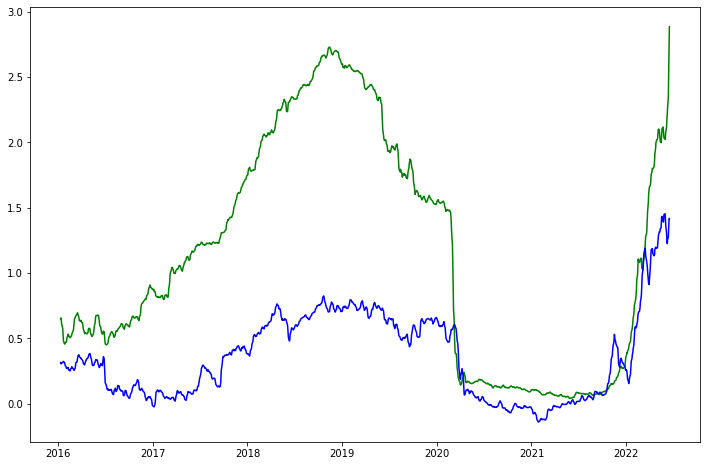

In [100]:
quick_plot(rolling_mean(window =5,US = True),rolling_mean(window =5,US = False),True)

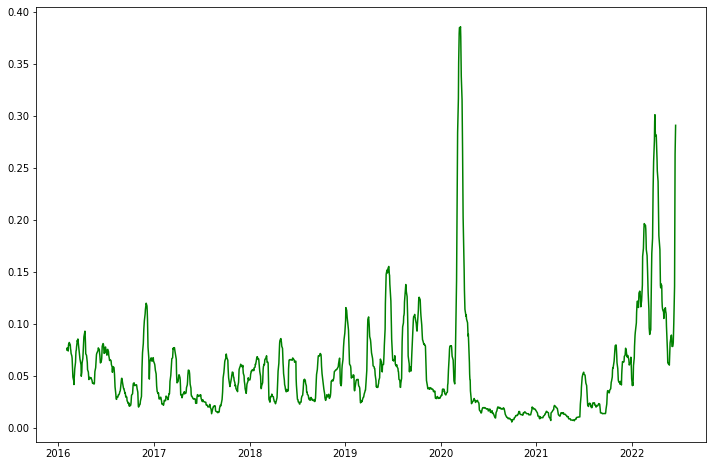

In [176]:
quick_plot(rolling_vol(window = 21,US = True, tenor = '2Y'))

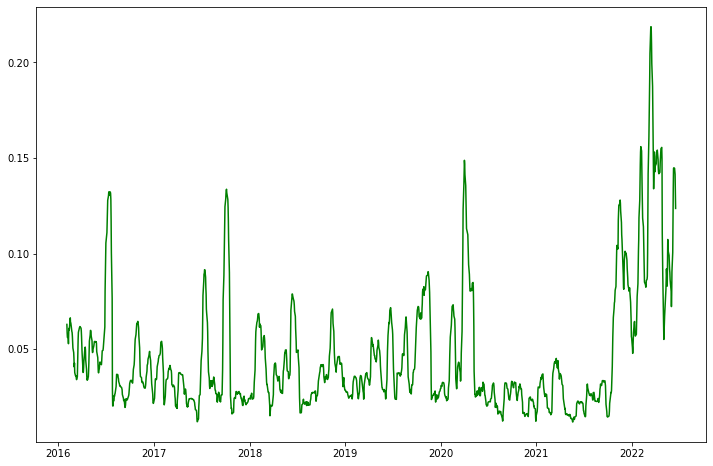

In [177]:
quick_plot(rolling_vol(window = 21,US = False, tenor = '2Y'))

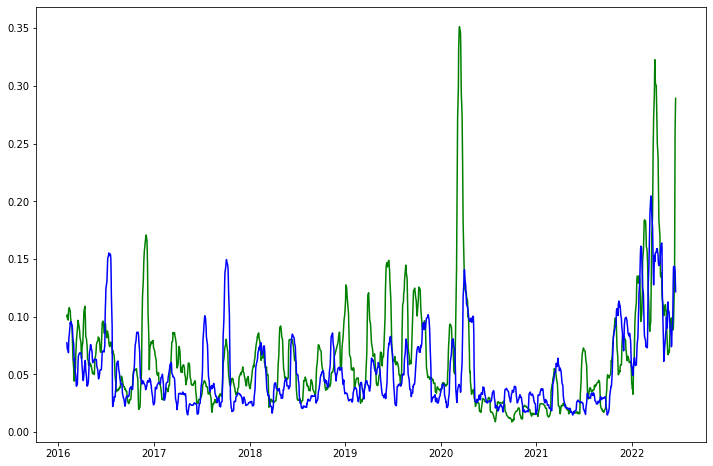

In [181]:
quick_plot(rolling_vol(window = 21,US = True, tenor = '3Y'),rolling_vol(window = 21,US = False, tenor = '3Y'),True)

Studying the monthly rates volatility shows a few interesting facts. 
- US suffered a large spike in volatilty during the pandemic, while the UK did not have that severe a spike.
- Both markets now see to be suffering rising volatilty, which makes sense given the uncertainty about the magnitudes of hikes and the potential evolution of inflation. 
- Interestingly, UK is now suffering higher volatility than the US on the short end of the yield curve, relative to each country's inital COVID spike. This may point towards the inherent difficulties the BoE faces right now since a major component of UK inflation is food and energy (both of which are supply-side constraints), whereas inflation in the US is relatively more broad-based (relatively more dependent on demand versus UK), which means the Fed has a more 'clearer' sense of direction, so to speak.
